<a href="https://colab.research.google.com/github/rgumi/seminararbeit/blob/master/final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy.stats import randint, uniform
import datetime as dt
import numpy as np
import pandas as pd 
import json
import urllib.request
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler

from collections import Counter
from xgboost.sklearn import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Data Preprocessing


In [0]:
def barplot(df, column):
  '''
    creates a barplot for the given data in df[column]
    -> shows the dustribution the successrate of the given data
    createa s boxplot for the given data in df[column]
  '''
  # get the count of each distinct values in series
  value_counts = pd.DataFrame()
  value_counts= df.loc[:, column].value_counts()
  value_counts_success = df[( df['success'] == 'Yes')].loc[:, column].value_counts()
  # create a plot for the bar graph


  sns.set_color_codes("pastel")
  sns.barplot(value_counts.index, value_counts.values, color="b",
              label="Total")

  sns.set_color_codes("muted")
  sns.barplot(value_counts_success.index, value_counts_success.values,
              color="b", label="Successful")
  

  plt.legend(ncol=2, loc="upper right", frameon=True)

In [0]:
df_eurostoxx= pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/eurostoxx_ref.csv', 
    index_col=['index'], parse_dates=['date'])

df_eurostoxx = df_eurostoxx[(df_eurostoxx['date'].dt.year >= 2007)]

def get_eurostoxx(date):
  for i in range(0, len(df_eurostoxx)):

    if date >= df_eurostoxx['date'].iloc[i]:
      last = df_eurostoxx['value'].iloc[i]
      continue
    return last

In [0]:
# https://www.financialresearch.gov/financial-stress-index/
df_fsi= pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/fsi_ref.csv', 
    index_col=['index'], parse_dates=['Date'])

df_fsi = df_fsi[(df_fsi['Date'].dt.year >= 2007)]

def get_fsi(date):
  for i in range(0, len(df_fsi)):

    if date >= df_fsi['Date'].iloc[i]:
      # Possible values: [OFR FSI, Credit, Equity valuation, Safe assets, Funding, Volatility]
      last = df_fsi['OFR FSI'].iloc[i]
      continue
    return last

In [0]:
df_cpi = pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/cpi_monthly_ref.csv', 
    index_col=['index'], parse_dates=['date'])

df_cpi = df_cpi[(df_cpi['date'].dt.year >= 2007)]

def get_cpi(date):
  for i in range(0, len(df_cpi)):

    if date >= df_cpi['date'].iloc[i]:
      last = df_cpi['value'].iloc[i]
      continue
    return last

In [0]:
ltz = {}
with urllib.request.urlopen("https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/leitzinsen_eu.json") as url:
    tmp_ltz = json.loads(url.read().decode())
for key in tmp_ltz.keys():
  ltz[dt.datetime.strptime(key, '%d-%m-%Y')] = tmp_ltz[key]
sorted_ltz = {k: ltz[k] for k in sorted(ltz)}

def get_base_rate(date):
  for key, val in sorted_ltz.items():
    if date >= key:
      last = val
      continue
    return last

In [7]:
dataset = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/master/datasets/prediction-challenge/dataset.csv', 
    index_col='identifier', parse_dates=['date'])

# insignificant because it is equally distributed between Mo to Fr
dataset.insert(len(dataset.columns) -1, "weekday", dataset.date.dt.weekday)
# grouped by quarter (reduce overcomplexity)
dataset.insert(len(dataset.columns) -1, "month", dataset.date.dt.month)
# partially replaced by financial measures
dataset.insert(len(dataset.columns) -1, "year", dataset.date.dt.year)

# significant because it can give insight on the intra-month distribution
dataset.insert(len(dataset.columns) -1, "day", dataset.date.dt.day)
# significant because it can give insight on the intra-year distribution
dataset.insert(len(dataset.columns) -1, "quarter", dataset.date.dt.quarter)

# Financial Measures
# give an insight in status of the financial markets
dataset.insert(len(dataset.columns)-1, "base_rate", dataset['date'].apply(get_base_rate))
dataset.insert(len(dataset.columns)-1, "cpi", dataset['date'].apply(get_cpi))
dataset.insert(len(dataset.columns)-1, "fsi", dataset['date'].apply(get_fsi))
dataset.insert(len(dataset.columns)-1, "eurostoxx", dataset['date'].apply(get_eurostoxx))

# replaced by the features above
dataset = dataset.drop('date', axis=1)

# To increase gap between 0, 1, ... values (existent contact) and -1 (non-existent)
dataset.loc[dataset['days_since_last_contact'] == -1, 'days_since_last_contact'] = 10000

dataset.columns

Index(['age', 'marital_status', 'education', 'job', 'credit_default',
       'housing_loan', 'personal_loan', 'communication_type',
       'n_contacts_campaign', 'days_since_last_contact', 'n_contacts_before',
       'previous_conversion', 'duration', 'weekday', 'month', 'year', 'day',
       'quarter', 'base_rate', 'cpi', 'fsi', 'eurostoxx', 'success'],
      dtype='object')

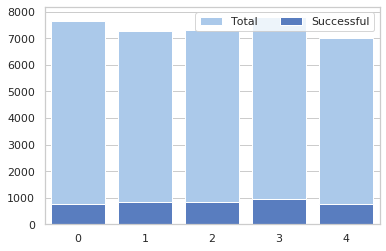

In [8]:
barplot(dataset, 'weekday')


In [0]:
all_features = ['day' ,'quarter', 'education', 'job', 'age', 
             'previous_conversion', 'n_contacts_before',
             'n_contacts_campaign', 'days_since_last_contact',
             'marital_status', 'credit_default', 'duration',
             'housing_loan', 'personal_loan', 'base_rate',
             'eurostoxx', 'fsi', 'cpi', 'communication_type']

categorical_features = ['education', 'job', 'previous_conversion',
                        'marital_status', 'quarter', 'credit_default',
                        'personal_loan', 'housing_loan', 'communication_type']

numerical_features = ['n_contacts_campaign', 'duration', 
                      'age', 'cpi', 'days_since_last_contact',
                      'base_rate', 'eurostoxx', 'fsi', 'day',
                      'n_contacts_before']


X = dataset[all_features]
y = dataset['success']
# Label Encoded
y = y.apply(lambda x: 1 if x == "Yes" else 0)

# --- 

# One-Hot Encoded
for item in categorical_features:
  try:
    encoded = pd.get_dummies(X[item], prefix=item)
    X.drop(item, axis=1, inplace=True)
    X = X.join(encoded)
  except Exception as e:
    print("Something went wrong?!")
    print(e)
    continue

# Normalization 
scaler = MinMaxScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Model Selection

The target variable of this problem is binary (Yes/No). Therefore, the model needs to be able to handle binary classification. The following models were selected for preselection:
1. Logistic Regression

2. Decision Tree (Random Forest)

3. Extreme Gradiant Boosting Classification (XGBClassifier)

In [0]:
# function which takes a model and the training data to run a 
# cross_validate with the f1-scorer
def validate_model(model, X, y):
  scoring=custom_scorer
  # performs a 10-fold-crossvalidate 3 times
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, 
                               random_state=1909)
  scores = cross_validate(model, X, y, scoring=scoring, cv=cv, 
                          n_jobs=-1, return_train_score=True)
  train_score = np.mean(scores["train_score"])*100
  test_score = np.mean(scores["test_score"])*100
  print(f'Mean F1 Score of {str(model).split("(")[0]}: {train_score:.2f}/{test_score:.2f}\n')
  return {
      'train': train_score,
      'test': test_score
      }

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
custom_scorer = make_scorer(f1_score, pos_label=1)

# The evaluation is done by running all models with the same preprocessed datasets
# Every model will use their default hyperparameters. No optimization has been conducted
# The evaluation is done with the F1 Score for all models using 
# a k-fold cross-validation (RepeatedStratifiedKFold)

model = LogisticRegression() # default hyperparameters
print(f'Evaluating Model: {str(model).split("(")[0]}')
lgr_score = validate_model(model, X, y)

model = RandomForestClassifier() # default hyperparameters
print(model)
print(f'Evaluating Model: {str(model).split("(")[0]}')
rfc_score = validate_model(model, X, y)

model = XGBClassifier() # default hyperparameters
print(model)
print(f'Evaluating Model: {str(model).split("(")[0]}')
xgbc_score = validate_model(model, X, y)

Evaluating Model: LogisticRegression
Mean F1 Score of LogisticRegression: 48.28/48.06

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Evaluating Model: RandomForestClassifier
Mean F1 Score of RandomForestClassifier: 99.99/53.39

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean F1 Score of XGBClassifier: 58.42/56.59



# Hyperparameter optimization

In [0]:
custom_scorer = make_scorer(f1_score, pos_label=1)

def gridsearch(model, param_grid, X, y):
  '''
  Takes a model, param_grid and datasets 
  to perform a grid search
  '''
  search = GridSearchCV(model, param_grid=param_grid, scoring=custom_scorer,
                    n_jobs=-1, cv=4, refit=True, error_score=0).fit(X, y)

  print(f'Optimal parameters: {search.best_params_}')
  print(f'Best Score: {search.best_score_}')
  return search.best_params_

def randsearch(model, param_distr, X, y):
  '''
  Takes a model, param_distribution and datasets 
  to perform a randomized search
  '''
  search = RandomizedSearchCV(model, param_distributions=param_distr, 
                              n_iter=10, scoring=custom_scorer, n_jobs=-1, 
                              cv=10, random_state=1909).fit(X, y)

  print(f'Optimal parameters: {search.best_params_}')
  print(f'Best Score: {search.best_score_}')
  return search.best_params_

In [0]:
# basis hyperparams
hyperparams = {
    'scale_pos_weight': 8, # = sum(negative instances) / sum(positive instances) for imbalanced datasets
    'gamma': 0, # minimum loss reduction needed to split a leaf node 
    'booster': 'gbtree', # => Decision Tree
    'objective': 'binary:logistic', # Outputs the Probability computed using a logistic function 
    'silent': True, 
    'missing': None,
    'nthread': -1,
    'random_state': 1909, # => Reproducibility
}

In [14]:
from scipy.stats import randint, uniform

custom_scorer = make_scorer(f1_score, pos_label=1)

n_estimators = randint(80, 150) # default 100
max_depth = randint(8, 50) # default 6
learning_rate = uniform(0.005, 0.3) # default 0.3

# regularization
gamma = randint(0, 5) # default 0
reg_lambda = randint(1, 5) # default 1

# subsampling
colsample_bynode = uniform(0.25, 1) # default 1
colsample_bylevel = uniform(0.25, 1) # default 1
colsample_bytree = uniform(0.25, 1) # default 1
subsample = uniform(0.25, 1) # default 1
base_score = uniform(0.2, 0.8) # default 0.5
min_child_weight = uniform(0.2, 1) # default 1

param_grid = {
    'n_estimators': n_estimators, # how many decision trees should be built
    'max_depth': max_depth, # how many levels are allowed in a tree
    'learning_rate': learning_rate, # eta of the gradient decent (step size)
    'subsample': subsample, # % of randomly sampled training data
    'colsample_bynode': colsample_bynode, # % of randomly sampled features per node
    'colsample_bylevel': colsample_bylevel, # % of randomly sampled features per level
    'colsample_bytree': colsample_bytree, # % of randomly sampled features per tree
    'base_score': base_score, # the base score (weight) every feature has at the start
    'min_child_weight': min_child_weight, # minimum needed sum of weights to split a leaf node
    # 'reg_lambda': reg_lambda, # L2 Regularization
    # 'gamma': gamma, # minimum loss reduction needed to further split a leaf node 
}

best_params = randsearch(XGBClassifier(**hyperparams), 
                         param_distr=param_grid, X=X, y=y)

Optimal parameters: {'base_score': 0.9002877650727912, 'colsample_bylevel': 0.9652028644880783, 'colsample_bynode': 0.3159502128331547, 'colsample_bytree': 0.8328197200519124, 'learning_rate': 0.11018223430025721, 'max_depth': 26, 'min_child_weight': 0.39171405586056623, 'n_estimators': 113, 'subsample': 0.4755162022020196}
Best Score: 0.6076429128687069


In [15]:
# with best parameters from optimization
f_hyperparams = {**hyperparams, **{
    'learning_rate': best_params['learning_rate'],
    'n_estimators': best_params['n_estimators'],
    'max_depth': best_params['max_depth'],
    'colsample_bylevel': best_params['colsample_bylevel'],
    'colsample_bynode': best_params['colsample_bynode'],
    'colsample_bytree': best_params['colsample_bytree'],
    'subsample': best_params['subsample'],
    'base_score': best_params['base_score'],
    'min_child_weight': best_params['min_child_weight'],
    }
}

model = XGBClassifier(**f_hyperparams)
print(model)
validate_model(model, X, y)

XGBClassifier(base_score=0.9002877650727912, booster='gbtree',
              colsample_bylevel=0.9652028644880783,
              colsample_bynode=0.3159502128331547,
              colsample_bytree=0.8328197200519124, gamma=0,
              learning_rate=0.11018223430025721, max_delta_step=0, max_depth=26,
              min_child_weight=0.39171405586056623, missing=None,
              n_estimators=113, n_jobs=1, nthread=-1,
              objective='binary:logistic', random_state=1909, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=8, seed=None, silent=True,
              subsample=0.4755162022020196, verbosity=1)
Mean F1 Score of XGBClassifier: 99.14/60.71



{'test': 60.70727332193293, 'train': 99.13929451164643}

# Prediction

In [0]:
prediction_dataset = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/master/datasets/prediction-challenge/prediction-dataset.csv', 
    index_col='identifier', parse_dates=['date'])

# insignificant because weekday is equally distributed
prediction_dataset.insert(len(prediction_dataset.columns) -1, "weekday", prediction_dataset.date.dt.weekday)

prediction_dataset.insert(len(prediction_dataset.columns) -1, "day", prediction_dataset.date.dt.day)

prediction_dataset.insert(len(prediction_dataset.columns) -1, "month", prediction_dataset.date.dt.month)

prediction_dataset.insert(len(prediction_dataset.columns) -1, "year", prediction_dataset.date.dt.year)

prediction_dataset.insert(len(prediction_dataset.columns) -1, "quarter", prediction_dataset.date.dt.quarter)

# financial measures
prediction_dataset.insert(len(prediction_dataset.columns)-1, "base_rate", prediction_dataset['date'].apply(get_base_rate))
prediction_dataset.insert(len(prediction_dataset.columns)-1, "cpi", prediction_dataset['date'].apply(get_cpi))
prediction_dataset.insert(len(prediction_dataset.columns)-1, "fsi", prediction_dataset['date'].apply(get_fsi))
prediction_dataset.insert(len(prediction_dataset.columns)-1, "eurostoxx", prediction_dataset['date'].apply(get_eurostoxx))

prediction_dataset = prediction_dataset.drop('date', axis=1)
prediction_dataset.columns

In [0]:
X_pred = prediction_dataset[all_features]

for item in categorical_features:
  try:
    encoded = pd.get_dummies(X_pred[item], prefix=item)
    X_pred.drop(item, axis=1, inplace=True)
    X_pred = X_pred.join(encoded)
  except Exception as e:
    print("Something went wrong?!")
    print(e)
    continue

scaler = MinMaxScaler()
X_pred[numerical_features] = scaler.fit_transform(X_pred[numerical_features])

# Add missing features to the prediction dataset at the position it has
# in the training dataset
for feature in X.columns:
  if not feature in X_pred.columns:
    print(f' X_pred is missing {feature}')
    X_pred.insert(X.columns.tolist().index(feature), feature, 0)

In [0]:
mountpath = "/content/drive"
from google.colab import drive
drive.mount(mountpath)

In [0]:
model = XGBClassifier(**f_hyperparams)
model.fit(X, y)
predictions = model.predict(X_pred)

submission = pd.DataFrame(
    predictions, index=X_pred.index, columns=['prediction'])

matriculation_number = '465527'

submission.to_csv(
    f'{mountpath}/My Drive/seminararbeit/result/submission-{matriculation_number}.csv', index_label='identifier')